In [1]:
import time
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# Import functional vessel routines
from jax_core.simulator.vessels.csad_jax import load_csad_parameters, csad_x_dot
# Import the RK4 integrator from your utils
from jax_core.utils import rk4_step, pipi
# Import the JONSWAP spectrum from your spectra module
from jax_core.simulator.waves.wave_spectra_jax import jonswap_spectrum
# Import functional wave load routines
from jax_core.simulator.waves.wave_load_jax_jit import init_wave_load, wave_load

print("JAX devices:", jax.devices())

JAX devices: [cuda(id=0)]


In [ ]:

start = time.time()
# --------------------------------------------------------------------------
# Simulation settings
# --------------------------------------------------------------------------
dt = 0.01
simtime = 100.0
t_array = jnp.arange(0, simtime, dt)
n_steps = t_array.shape[0]

# --------------------------------------------------------------------------
# Load vessel parameters and set up initial state (functional style)
# --------------------------------------------------------------------------
config_file = "data/vessel_data/csad/csad.json"
params_jit = load_csad_parameters(config_file)

print(f"Init boat took {time.time() - start:.2f} seconds")
eta_init = jnp.zeros(6)
nu_init  = jnp.zeros(6)
x = jnp.concatenate([eta_init, nu_init])

Init boat took 0.92 seconds


In [3]:

start = time.time()
# --------------------------------------------------------------------------
# Define wave parameters & initialize wave load (functional style)
# --------------------------------------------------------------------------
# No current
Uc = 0.0
beta_c = 0.0

hs = 5.0 / 90.0            # Significant wave height
tp = 9.0 * jnp.sqrt(1/90)    # Peak period
gamma = 3.3                # JONSWAP peak factor

wp = 2 * jnp.pi / tp       # Peak frequency
wmin = 0.5 * wp
wmax = 3.0 * wp

N = 100  # Number of wave components
wave_freqs = jnp.linspace(wmin, wmax, N)  # Frequencies in rad/s

# Compute wave spectrum using our JONSWAP functional spectrum
omega, wave_spectrum = jonswap_spectrum(wave_freqs, hs, tp, gamma=gamma, freq_hz=False)
dw = (wmax - wmin) / N
wave_amps = jnp.sqrt(2.0 * wave_spectrum * dw)

# Random phases and incident angles
key = jax.random.PRNGKey(42)
rand_phase = jax.random.uniform(key, shape=(N,), minval=0, maxval=2*jnp.pi)
wave_angles = jnp.ones(N) * (jnp.pi / 4)

# Initialize the wave load dictionary (pure functional style)
wl = init_wave_load(
    wave_amps=wave_amps,
    freqs=wave_freqs,
    eps=rand_phase,
    angles=wave_angles,
    config_file=config_file,
    rho=1025,
    g=9.81,
    dof=6,
    depth=100,
    deep_water=True,
    qtf_method="Newman",
    qtf_interp_angles=True,
    interpolate=True
)

print(f"Init the everything related to the waves took {time.time() - start:.2f} seconds")

***************************************Generate QTF matrices****************************************
Using Newman

***************************************QTF matrices complete.***************************************
Init the everything related to the waves took 5.52 seconds


In [4]:
# --------------------------------------------------------------------------
# Simulation loop: use the RK4 integrator and pure functions with jax.lax.scan
# --------------------------------------------------------------------------
print("Starting simulation")
start = time.time()
tau_control = jnp.zeros(6)

# Modify the simulation_step to record both the state and the wave load
def simulation_step(x, t):
    # Extract the vessel position (first 6 elements)
    eta = x[:6]
    # Make sure that heading is between (-pi, pi)
    eta = eta.at[6 // 6 + 2 :].set(pipi(eta[6 // 6 + 2 :]))
    # Compute the wave load at time t for given state eta
    tau_wave = wave_load(t, eta, wl)
    # Combine the control input with the wave load
    tau = tau_control + tau_wave
    # Advance the state using the RK4 integrator
    x_next = rk4_step(x, dt, csad_x_dot, Uc, beta_c, tau, params_jit)
    # Use x_next as the new carry, and output a tuple: (state, wave load)
    return x_next, (x_next, tau_wave)

# Run the scan: this returns the final state (x_final) and a tuple containing all outputs.
x_final, outputs = jax.lax.scan(simulation_step, x, t_array)
# Unpack the outputs: states and wave loads over all time steps.
states, wave_loads = outputs

print(f"Simulation took {time.time() - start:.2f} seconds")
print(f"Simtime/Real: {simtime / (time.time() - start):.2f}")

Starting simulation
Simulation took 3.05 seconds
Simtime/Real: 32.74


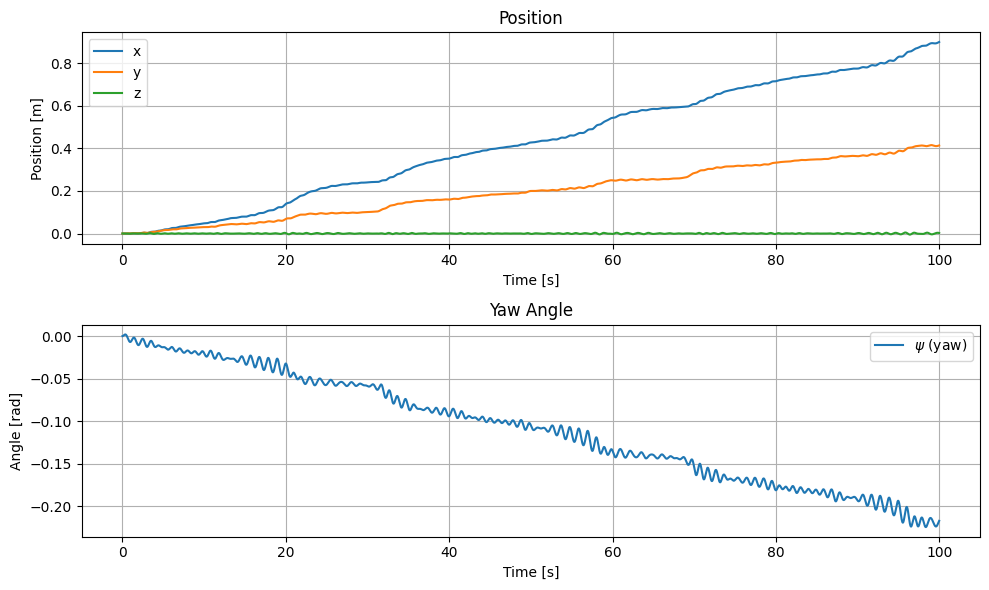

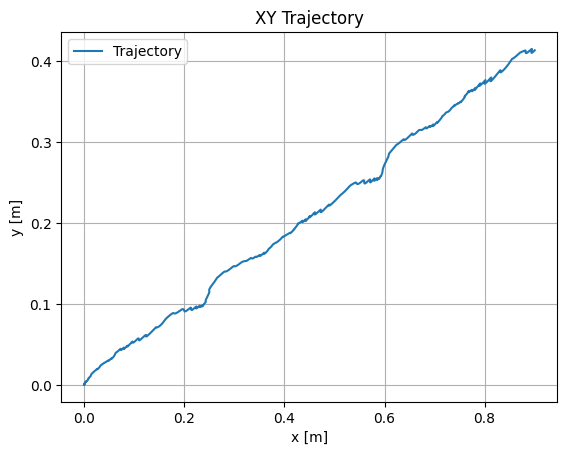

In [5]:
# Process states to get vessel positions and velocities
eta_result = states[:, :6].T   # shape (6, n_steps)
nu_result  = states[:, 6:].T    

# ----------------------------------------------------------------------------
# Plot vessel states (positions and yaw angle) as before
# ----------------------------------------------------------------------------
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
axes[0].plot(t_array, eta_result[0, :], label='x')
axes[0].plot(t_array, eta_result[1, :], label='y')
axes[0].plot(t_array, eta_result[2, :], label='z')
axes[0].legend()
axes[0].grid()
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Position [m]')
axes[0].set_title('Position')

axes[1].plot(t_array, eta_result[5, :], label=r'$\psi$ (yaw)')
axes[1].legend()
axes[1].grid()
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Angle [rad]')
axes[1].set_title('Yaw Angle')

plt.tight_layout()
plt.show()

plt.figure()
plt.plot(eta_result[0, :], eta_result[1, :], label='Trajectory')
plt.grid()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('XY Trajectory')
plt.legend()
plt.show()


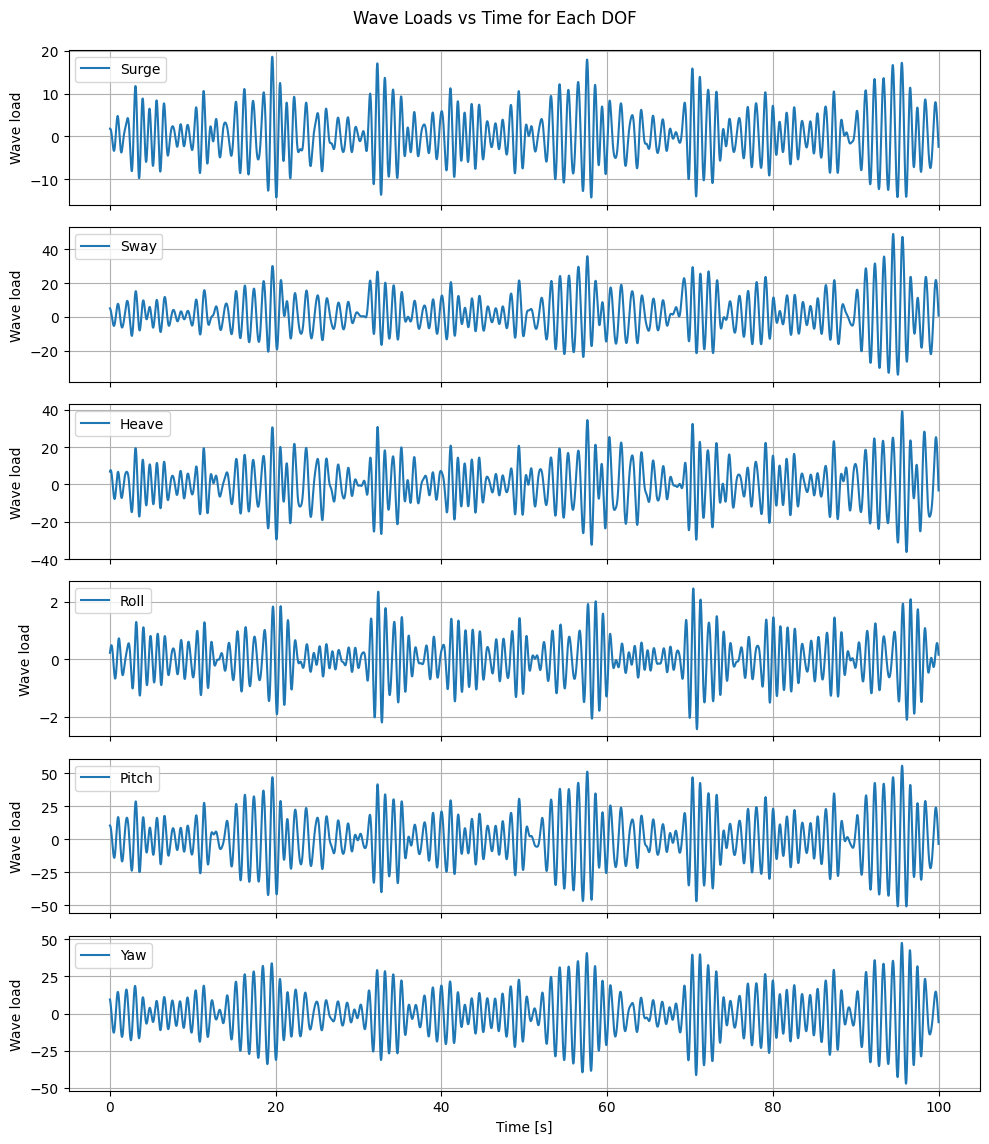

In [6]:
# ----------------------------------------------------------------------------
# Plot the wave loads vs time for each degree of freedom (DOF)
# ----------------------------------------------------------------------------
# Note: wave_loads is an array with shape (n_steps, 6) if tau_wave is a 6-element vector.
wave_loads_np = np.array(wave_loads)  # Convert from JAX array to NumPy, shape: (n_steps, 6)

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 12), sharex=True)
dof_labels = ['Surge', 'Sway', 'Heave', 'Roll', 'Pitch', 'Yaw']

for i in range(6):
    axes[i].plot(t_array, wave_loads_np[:, i], label=f'{dof_labels[i]}')
    axes[i].set_ylabel('Wave load')
    axes[i].legend()
    axes[i].grid()

axes[-1].set_xlabel('Time [s]')
fig.suptitle('Wave Loads vs Time for Each DOF', y=0.95)  # Adjusted y position
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
plt.show()